# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.regularizers import l2
import random

# Import Data

In [2]:
df = pd.read_csv('Processed_Data.csv')

In [3]:
df.head()

Unnamed: 0   Gold  Silver    Oil  US Dollar  S&P 500  Interest  Inflation  \
0  2000-08-30  273.9    4.93  33.40     112.14  1502.59  3.045613   2.875701   
1  2000-08-31  278.3    5.00  33.10     112.60  1517.68  3.045613   2.875701   
2  2000-09-01  277.0    5.00  33.38     111.42  1520.77  2.885996   3.068734   
3  2000-09-04  277.0    5.00  33.38     111.42  1520.77  2.885996   3.068734   
4  2000-09-05  275.8    5.00  33.80     112.41  1507.08  2.885996   3.068734   

   Unrate  
0     4.1  
1     4.1  
2     3.9  
3     3.9  
4     3.9

In [4]:
import plotly.express as px
fig = px.line(df, y="Gold", title="Interactive Gold Price Over Time")
fig.show()

# Data Preprocessing

In [5]:
df = df.rename(columns = {"Unnamed: 0" : "Date"})

In [6]:
df["Date"] = pd.to_datetime(df["Date"] , format = "%Y-%m-%d")

In [7]:
df = df.set_index("Date")

In [8]:
df = df.reset_index(drop = True)

In [9]:
df.head()

Gold  Silver    Oil  US Dollar  S&P 500  Interest  Inflation  Unrate
0  273.9    4.93  33.40     112.14  1502.59  3.045613   2.875701     4.1
1  278.3    5.00  33.10     112.60  1517.68  3.045613   2.875701     4.1
2  277.0    5.00  33.38     111.42  1520.77  2.885996   3.068734     3.9
3  277.0    5.00  33.38     111.42  1520.77  2.885996   3.068734     3.9
4  275.8    5.00  33.80     112.41  1507.08  2.885996   3.068734     3.9

In [10]:
df.tail()

Gold  Silver    Oil  US Dollar  S&P 500  Interest  Inflation  Unrate
6302  2740.9   33.60  71.78     104.26  5808.12  1.480148   3.607369     4.1
6303  2742.9   33.83  67.38     104.32  5823.52  1.480148   3.607369     4.1
6304  2768.4   34.27  67.21     104.28  5832.92  1.480148   3.607369     4.1
6305  2788.5   33.91  68.61     103.99  5813.67  1.480148   3.607369     4.1
6306  2738.3   32.65  69.26     103.98  5705.45  1.480148   3.607369     4.1

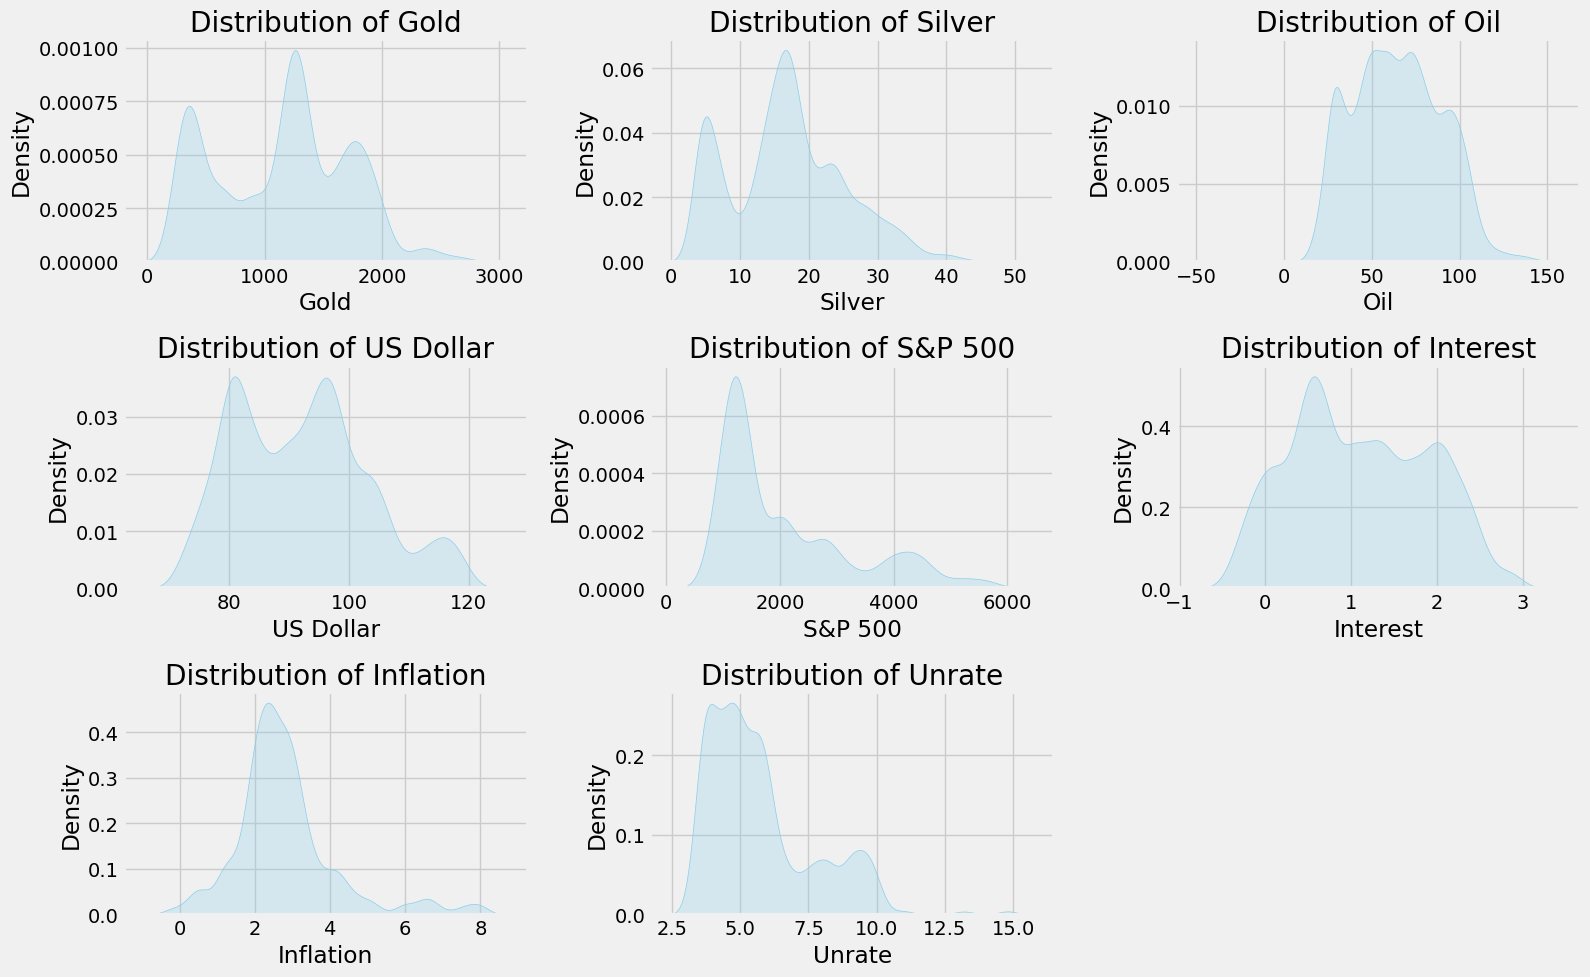

In [11]:
features = df.columns
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.kdeplot(df[feature], fill=True, color='skyblue')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Scailing

### Min Max Scaler

In [12]:
df_col = df.columns
df_col = df_col.drop('Gold')

In [13]:
f_scaler = MinMaxScaler()
t_scaler = MinMaxScaler()

df[df_col] = f_scaler.fit_transform(df[df_col])

In [14]:
df.head()

Gold    Silver       Oil  US Dollar   S&P 500  Interest  Inflation  \
0  273.9  0.020202  0.388312   0.823280  0.159221  1.000000   0.379377   
1  278.3  0.021773  0.386672   0.832560  0.162129  1.000000   0.379377   
2  277.0  0.021773  0.388202   0.808755  0.162725  0.953771   0.402539   
3  277.0  0.021773  0.388202   0.808755  0.162725  0.953771   0.402539   
4  275.8  0.021773  0.390499   0.828727  0.160086  0.953771   0.402539   

     Unrate  
0  0.061404  
1  0.061404  
2  0.043860  
3  0.043860  
4  0.043860

In [15]:
df[['Gold']] = t_scaler.fit_transform(df[['Gold']])

In [16]:
df.head()

Gold    Silver       Oil  US Dollar   S&P 500  Interest  Inflation  \
0  0.007421  0.020202  0.388312   0.823280  0.159221  1.000000   0.379377   
1  0.009158  0.021773  0.386672   0.832560  0.162129  1.000000   0.379377   
2  0.008645  0.021773  0.388202   0.808755  0.162725  0.953771   0.402539   
3  0.008645  0.021773  0.388202   0.808755  0.162725  0.953771   0.402539   
4  0.008171  0.021773  0.390499   0.828727  0.160086  0.953771   0.402539   

     Unrate  
0  0.061404  
1  0.061404  
2  0.043860  
3  0.043860  
4  0.043860

In [17]:
df.tail()

Gold    Silver       Oil  US Dollar   S&P 500  Interest  Inflation  \
6302  0.981211  0.663749  0.598130   0.664313  0.989100  0.546603   0.467169   
6303  0.982000  0.668911  0.574076   0.665524  0.992068  0.546603   0.467169   
6304  0.992066  0.678788  0.573147   0.664717  0.993880  0.546603   0.467169   
6305  1.000000  0.670707  0.580800   0.658866  0.990170  0.546603   0.467169   
6306  0.980185  0.642424  0.584354   0.658665  0.969311  0.546603   0.467169   

        Unrate  
6302  0.061404  
6303  0.061404  
6304  0.061404  
6305  0.061404  
6306  0.061404

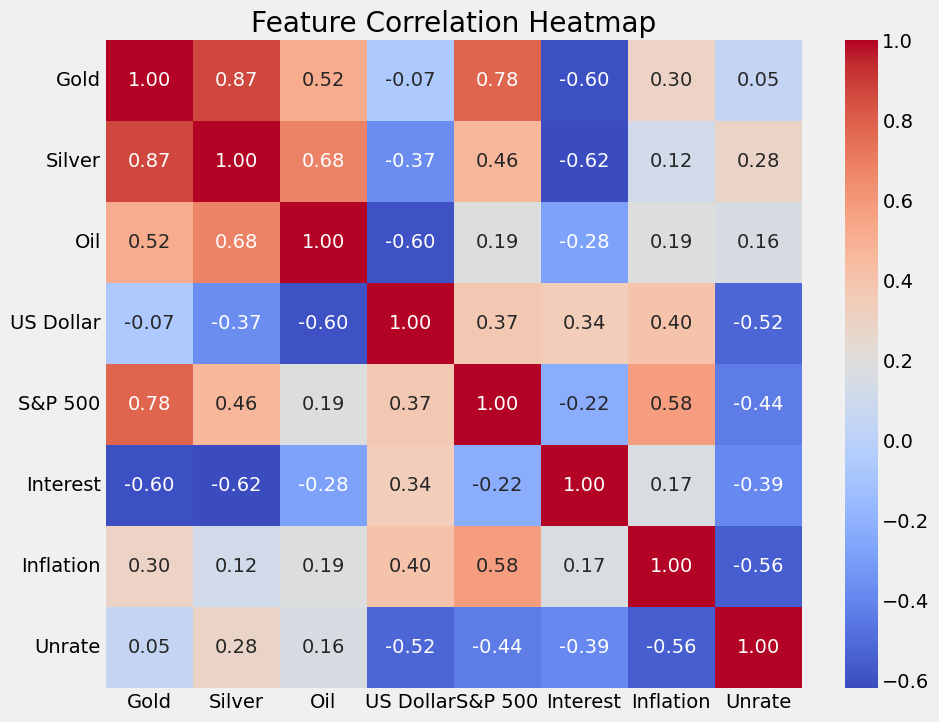

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

### Svave Scalers

In [19]:
import joblib


joblib.dump(f_scaler, "feature_scaler.pkl")
joblib.dump(t_scaler, "target_scaler.pkl")

['target_scaler.pkl']

# Sequences Function

In [20]:
def create_sequences(data, seq_length):
    X, y = [], []
    
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length])
        y.append(data.iloc[i+seq_length]['Gold'])
        
    return np.array(X), np.array(y)

In [21]:
seq_length = 1

X, y = create_sequences(df, seq_length)

In [22]:
print(X)
print(y)

[[[0.00742086 0.02020202 0.38831183 ... 1.         0.37937686 0.06140351]]

 [[0.00915765 0.02177329 0.38667177 ... 1.         0.37937686 0.06140351]]

 [[0.00864451 0.02177329 0.38820249 ... 0.95377099 0.40253876 0.04385965]]

 ...

 [[0.98200047 0.66891134 0.5740761  ... 0.54660309 0.46716899 0.06140351]]

 [[0.992066   0.67878788 0.57314673 ... 0.54660309 0.46716899 0.06140351]]

 [[1.         0.67070707 0.58080035 ... 0.54660309 0.46716899 0.06140351]]]
[0.00915765 0.00864451 0.00864451 ... 0.992066   1.         0.98018473]


# Sequences Selection

In [43]:
seq_list = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 32, 34, 36, 38, 40]
r2_list = []

for i in seq_list:
    X, y = create_sequences(df, i)
    
    test_size = 0.15  # 15% test set
    split_idx = int(len(X) * (1 - test_size))
    X_train_val, X_test = X[:split_idx], X[split_idx:]
    y_train_val, y_test = y[:split_idx], y[split_idx:]
    
    # TimeSeriesSplit configuration
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    
    # Cross-validation loop
    val_losses = []
    input_shape = (X_train_val.shape[1], X_train_val.shape[2])

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_val)):
        print(f"\nFold {fold + 1}/{n_splits}")
    
        # Split data for this fold
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
    
        # Create and train model
        model = create_model(input_shape)
        early_stopping = EarlyStopping(monitor='val_loss', patience=17, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=16, min_lr=0.0001)
    
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
    
        # Record validation loss
        val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")
        
    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform
    y_test_inv = t_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = t_scaler.inverse_transform(y_pred).flatten()

    r2 = r2_score(y_test_inv, y_pred_inv)

    r2_list.append(r2)


Fold 1/5
Validation Loss: 0.0008

Fold 2/5
Validation Loss: 0.0008

Fold 3/5
Validation Loss: 0.0001

Fold 4/5
Validation Loss: 0.0000

Fold 5/5
Validation Loss: 0.0001
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Fold 1/5
Validation Loss: 0.0009

Fold 2/5
Validation Loss: 0.0001

Fold 3/5
Validation Loss: 0.0002

Fold 4/5
Validation Loss: 0.0000

Fold 5/5
Validation Loss: 0.0003
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Fold 1/5
Validation Loss: 0.0007

Fold 2/5
Validation Loss: 0.0015

Fold 3/5
Validation Loss: 0.0002

Fold 4/5
Validation Loss: 0.0001

Fold 5/5
Validation Loss: 0.0002
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Fold 1/5
Validation Loss: 0.0012

Fold 2/5
Validation Loss: 0.0010

Fold 3/5
Validation Loss: 0.0003

Fold 4/5
Validation Loss: 0.0001

Fold 5/5
Validation Loss: 0.0003
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Fold 1/5
Validation Loss: 0.0013

Fold 2/5
Validation Loss: 0.0038

Fold 3/5
Validation Loss: 0.0003

Fold 4/5
Validation Loss: 0.0000

Fold 5/5
Validation Los

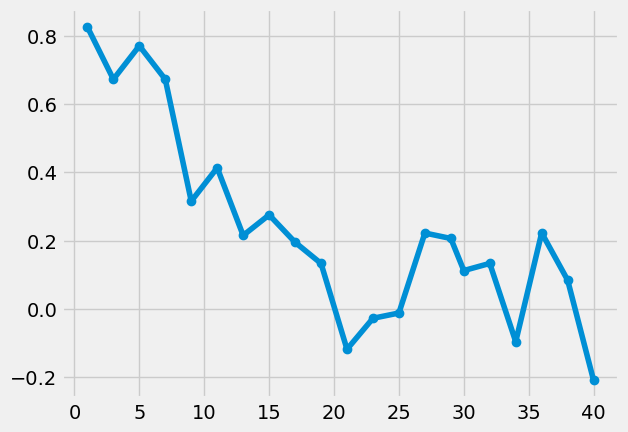

In [50]:
plt.plot(seq_list, r2_list, marker = 'o')
plt.show();

# Time Series Data Split

In [23]:
test_size = 0.20  # 20% test set
split_idx = int(len(X) * (1 - test_size))
X_train_val, X_test = X[:split_idx], X[split_idx:]
y_train_val, y_test = y[:split_idx], y[split_idx:]

# TimeSeriesSplit configuration
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Model Building

In [24]:
def create_model(input_shape):
    
    model = Sequential()
    
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model

# Model Training

In [29]:
# Cross-validation loop
val_losses = []
input_shape = (X_train_val.shape[1], X_train_val.shape[2])

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_val)):
    print(f"\nFold {fold + 1}/{n_splits}")
    
    # Split data for this fold
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
    
    # Create and train model
    model = create_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=17, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=16, min_lr=0.0001)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    
    # Record validation loss
    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")


Fold 1/5
Validation Loss: 0.0002

Fold 2/5
Validation Loss: 0.0038

Fold 3/5
Validation Loss: 0.0002

Fold 4/5
Validation Loss: 0.0000

Fold 5/5
Validation Loss: 0.0000


# Model Validation

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


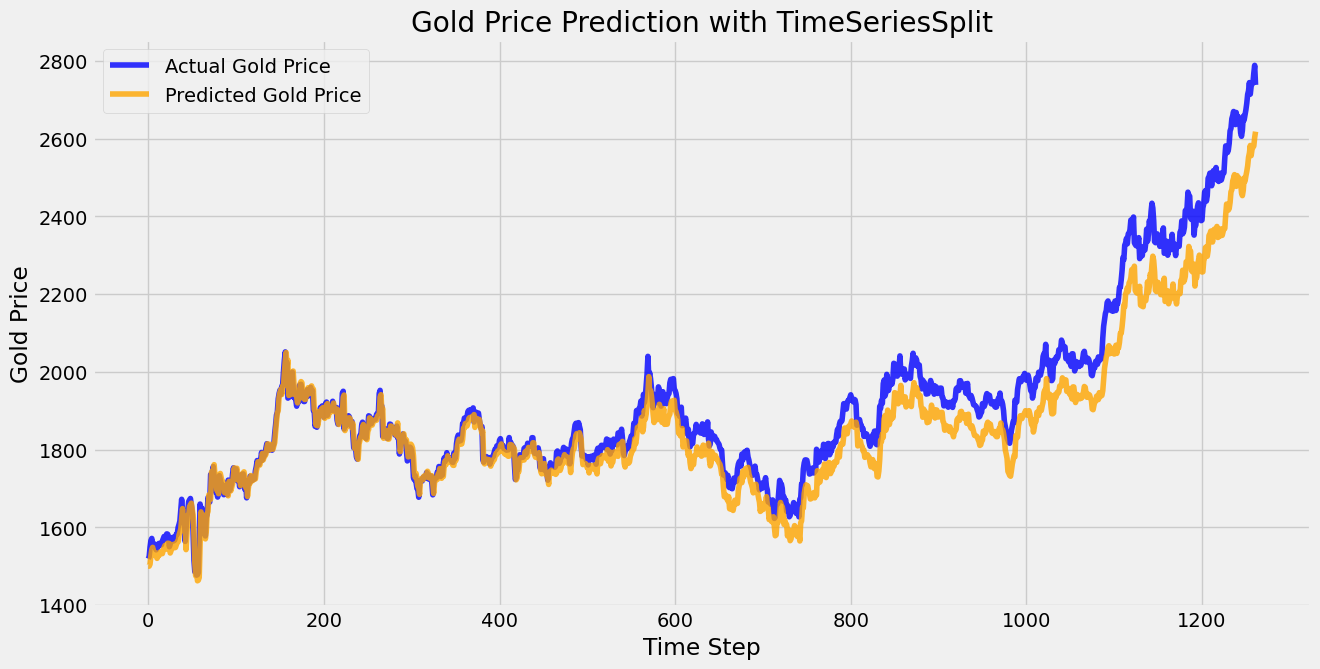


R² Score: 90.70%
Average Validation Loss: 0.0009


In [30]:
y_pred = model.predict(X_test)

# Inverse transform
y_test_inv = t_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = t_scaler.inverse_transform(y_pred).flatten()

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Gold Price', color='blue', alpha=0.8)
plt.plot(y_pred_inv, label='Predicted Gold Price', color='orange', alpha=0.8)
plt.title('Gold Price Prediction with TimeSeriesSplit')
plt.xlabel('Time Step')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()

r2 = r2_score(y_test_inv, y_pred_inv)
print(f"\nR² Score: {r2 * 100:.2f}%")
print(f"Average Validation Loss: {np.mean(val_losses):.4f}")

# Train Validation

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


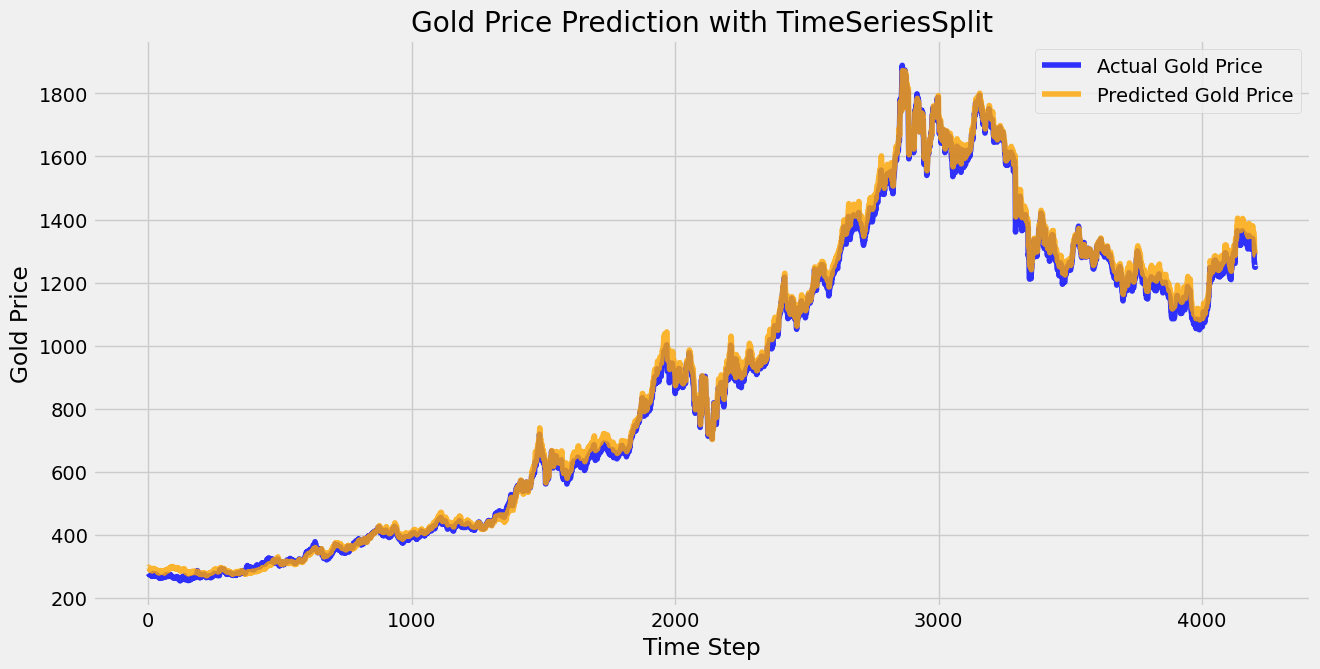


R² Score: 99.75%


In [24]:
y_pred_train = model.predict(X_train)

# Inverse transform
y_train_inv = t_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_pred_inv_train = t_scaler.inverse_transform(y_pred_train).flatten()

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(y_train_inv, label='Actual Gold Price', color='blue', alpha=0.8)
plt.plot(y_pred_inv_train, label='Predicted Gold Price', color='orange', alpha=0.8)
plt.title('Gold Price Prediction with TimeSeriesSplit')
plt.xlabel('Time Step')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()

r2 = r2_score(y_train_inv, y_pred_inv_train)
print(f"\nR² Score: {r2 * 100:.2f}%")

In [89]:
model.save_weights('LSTM_1_cv5.weights.h5')

# Load Best Model

In [25]:
model.load_weights('LSTM_1_cv5.weights.h5') 

# Test Evaluation

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


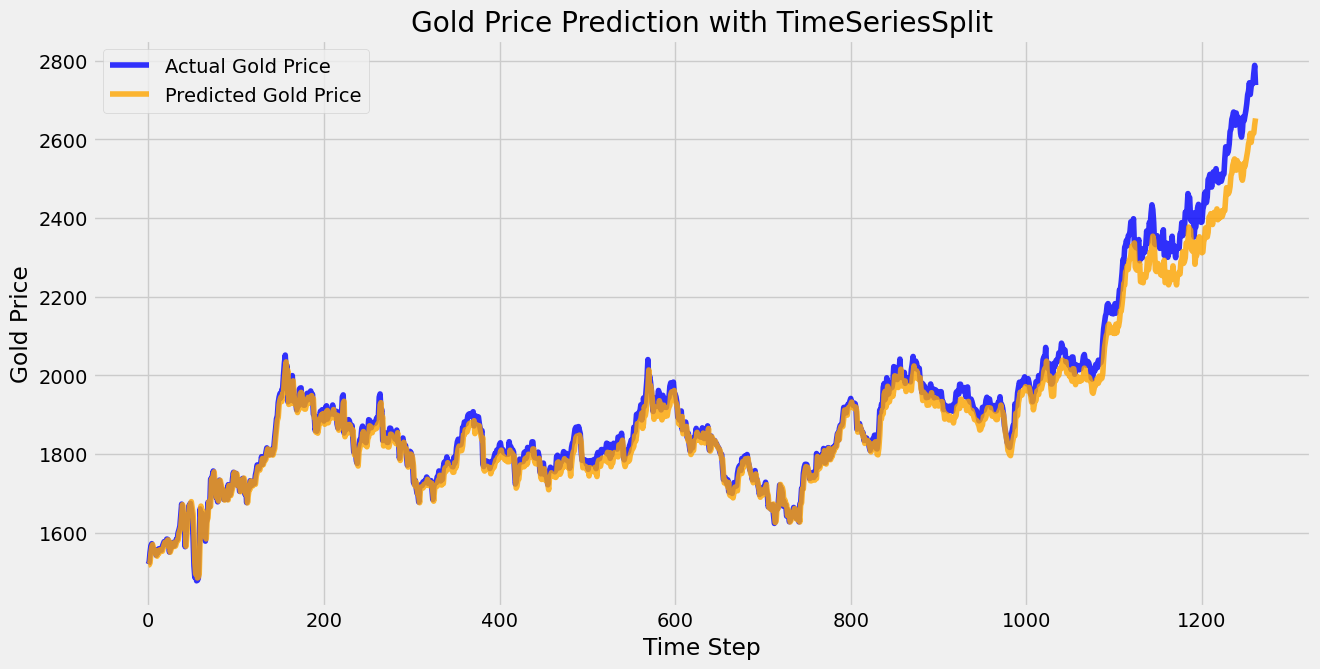


R² Score: 97.01%
Average Validation Loss: 0.0008
Mean Absolute Error (MAE): 29.1248
Mean Squared Error (MSE): 1654.2956
Root Mean Squared Error (RMSE): 40.6730
Mean Absolute Percentage Error (MAPE): 1.42%


In [26]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform
y_test_inv = t_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = t_scaler.inverse_transform(y_pred).flatten()

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Gold Price', color='blue', alpha=0.8)
plt.plot(y_pred_inv, label='Predicted Gold Price', color='orange', alpha=0.8)
plt.title('Gold Price Prediction with TimeSeriesSplit')
plt.xlabel('Time Step')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()

r2 = r2_score(y_test_inv, y_pred_inv)
print(f"\nR² Score: {r2 * 100:.2f}%")
print(f"Average Validation Loss: {np.mean(val_losses):.4f}")

mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Mean Squared Error (MSE): {mse:.4f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Training Evaluation

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


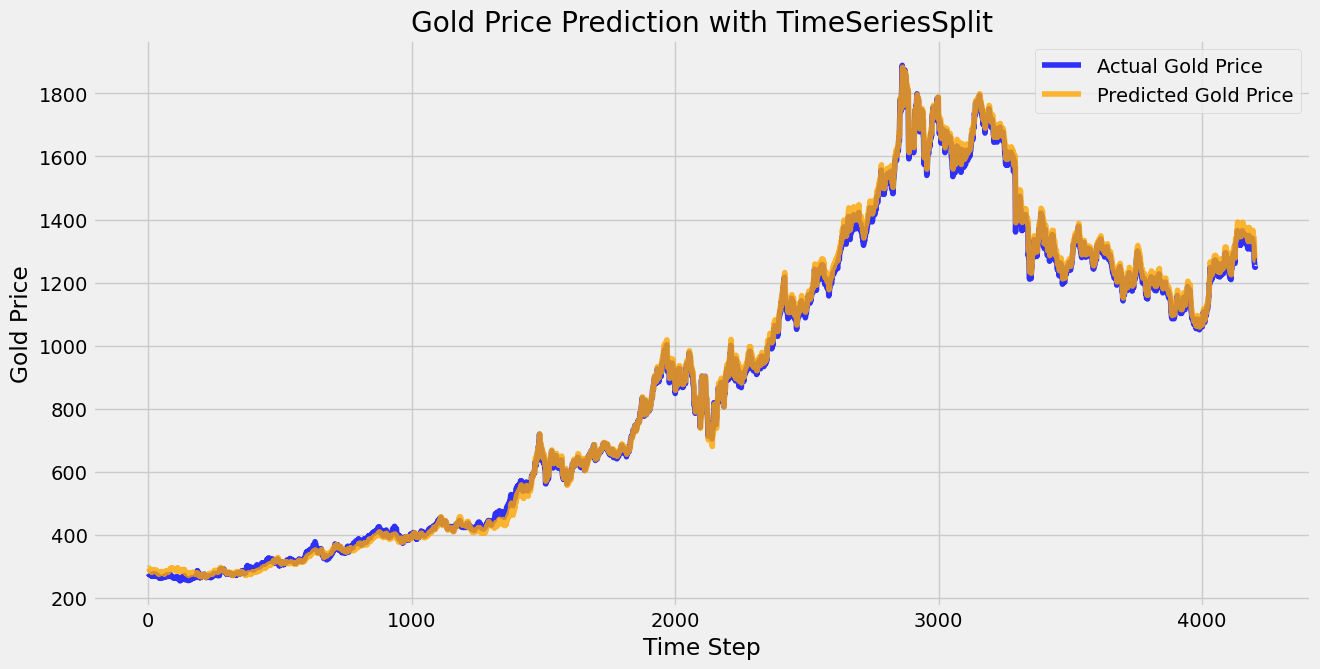


R² Score: 99.84%
Average Validation Loss: 0.0008
Mean Absolute Error (MAE): 14.3109
Mean Squared Error (MSE): 341.5522
Root Mean Squared Error (RMSE): 18.4811
Mean Absolute Percentage Error (MAPE): 2.01%


In [27]:
y_pred_train = model.predict(X_train)

# Inverse transform
y_train_inv = t_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_pred_inv_train = t_scaler.inverse_transform(y_pred_train).flatten()

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(y_train_inv, label='Actual Gold Price', color='blue', alpha=0.8)
plt.plot(y_pred_inv_train, label='Predicted Gold Price', color='orange', alpha=0.8)
plt.title('Gold Price Prediction with TimeSeriesSplit')
plt.xlabel('Time Step')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()


r2 = r2_score(y_train_inv, y_pred_inv_train)
print(f"\nR² Score: {r2 * 100:.2f}%")
print(f"Average Validation Loss: {np.mean(val_losses):.4f}")

mae = mean_absolute_error(y_train_inv, y_pred_inv_train)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

mse = mean_squared_error(y_train_inv, y_pred_inv_train)
print(f"Mean Squared Error (MSE): {mse:.4f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_train_inv, y_pred_inv_train)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

In [72]:
model.save('lstm_model_97%.keras')